# Define The Approach:

## Let's try 2 different approaches to classifying MNIST
## 1. Softmax Regression
## 2. Neural Network

### **Import packages**

In [ ]:
import pandas as pd
import torch
from torch import Tensor
# Run to make sure fastai runs in colab
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from keras.utils.np_utils import to_categorical
import time
fastbook.setup_book()

     |████████████████████████████████| 727kB 26.2MB/s 
     |████████████████████████████████| 1.2MB 20.5MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 204kB 41.2MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
Mounted at /content/gdrive


In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
Path.Base_PATH = path

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [ ]:
#Getting the training datasets ready
'''
Important info:
#training images = 60,000
Each of the categories having roughly equal distribution: train_y.unique(return_counts=True)
'''
train_images_list = get_image_files(path/'training')
train_x_list = [tensor(Image.open(img_path)) for img_path in train_images_list]
train_y_list = [int(img_path.parent.name) for img_path in train_images_list]
train_x = (torch.stack(train_x_list).float()/255).view(-1,28*28)
train_y = tensor(train_y_list).view(-1,1)

train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [ ]:
train_dset = list(zip(train_x, train_y))


In [ ]:
#Getting the validation datasets ready
'''
Important info:
#validation images = 10,000
Each of the categories having roughly equal distribution: valid_y.unique(return_counts=True)
'''
valid_images_list = get_image_files(path/'testing')
valid_x_list = [tensor(Image.open(img_path)) for img_path in valid_images_list]
valid_y_list = [int(img_path.parent.name) for img_path in valid_images_list]
valid_x = (torch.stack(valid_x_list).float()/255).view(-1,28*28)
valid_y = tensor(valid_y_list).view(-1,1)

valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [ ]:
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
#dls = ImageDataLoaders.from_folder(path, train='training',valid='testing')
#learn = cnn_learner(dls, resnet18, pretrained=False,
#                    loss_func=F.cross_entropy, metrics=accuracy, n_out=10)
#learn.fit_one_cycle(1, 0.1)

### **Softmax Regression**

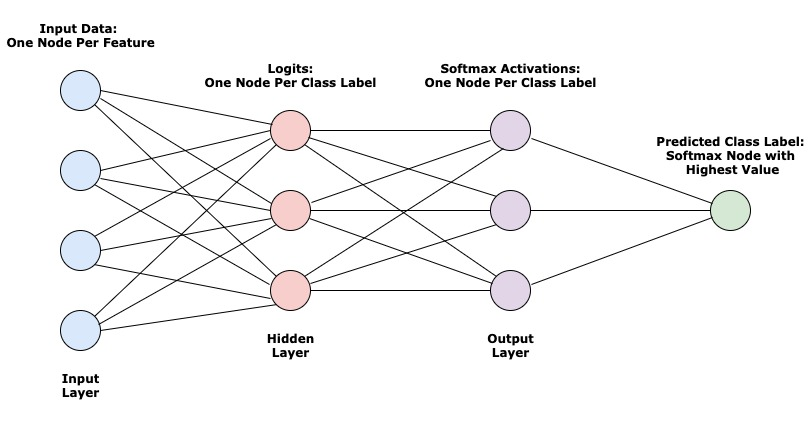

We are going to start with some input data in the above picture our inputs have the dimension of (m x 4), that's why there are 4 nodes.

Each feature/columns of the input is mapped to every node in the hidden layer making it a fully connected network. The nodes are floating point numbers referred to as logits and are the result of multiplying every input by a set of weights that are unique to the node and adding a bias.

The output of X@w + b which is the logits then get transformed by being passed through a activation function usually a sigmoid function that takes a input and produces and output between 0 and 1, which represents a probability that that row of data has a particular label.

In the final layer the node in the output layer with the highest probability is chosen and that is then the predicted class

One iteration of the model training process for a network like this can be split up into two sections - the forward pass and backward pass.

Forward Pass: Starts at the input layer and ends with the output layer and predicted class. The performance of the forward pass is evaluated through the calculation of a loss function that tells the model how well or bad it is doing. 

Backward Pass: Once we have the training loss, we use that to go back through the network and make adjustments to the parameters of all the hidden layers in order to reduce the loss and improve the prediction this optimization step is done with Gradient Descent. 

Steps:

1. Initialization
2. Predict
3. Loss
4. Calculate gradient 
5. Update Parameters
6. Back to step 2
7. Stop

### **Read The Data**

In [ ]:
X = torch.tensor(train_x, dtype=torch.float32)
y = torch.tensor(train_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
y.shape, y.unique()

(torch.Size([60000, 1]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

One-Hot Encode Class Labels:


$% <![CDATA[
\begin{equation*}
y = 
\begin{bmatrix}
1 \\
2 \\
1 \\
0 \\
2 \\
0
\end{bmatrix}
\implies
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0
\end{bmatrix}
\end{equation*} %]]>$

This is an important technique for preprocessing certain categorical features in your training data as well. For this use case it just makes some computations easier.

Get the number of unique values in y.
Create a tensor of zeros with shape (n_training_samples, n_classes).
Use the scatter method to replace zeros in one_hot where there should be a 1 to represent that a given row is of the specific iris type.
The first argument is the axis along which to work, which in this case is 1 for the second dimension (across rows).
The second argument supplies indices that represent the column in each row that will get a 1. The trick here is that we already encoded the Iris labels with integers 0, 1, and 2, which happen to also specify valid columns.
The last argument is the value(s) we want to impute, which in this case is just 1 for every row.

In [ ]:
def one_hot_encode(vector):
  classes = len(vector.unique())
  one_hot = torch.zeros((vector.shape[0], classes)).type(torch.LongTensor)
  return one_hot.scatter(1,y.type(torch.LongTensor), 1)

y_one_hot = one_hot_encode(y)

In [ ]:
def one_hot(y, c):
    
    # y--> label/ground truth.
    # c--> Number of classes.
    
    # A zero matrix of size (m, c)
    y_hot = torch.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[torch.arange(len(y)), y] = 1
    
    return y_hot

In [ ]:
y_one_hot2 = one_hot(y, 10)

In [ ]:
y_one_hot.shape, y_one_hot2.shape

(torch.Size([60000, 10]), torch.Size([60000, 10]))

### **Initialize Model Parameters**

Each example will be represented by a fixed length vector (1D tensor). Since each example in the raw dataset is 28x28 pixel image, we flatten the image and will treat it as a 1D vector with lenght 784. 

Since we are doing sofmax regression which is a multiclass classification our output will have 10 categories. Therefore the weights will be 784 x 10 matrix and the biases will be 1 x 10 row vector.

We initialize our weights `w` with Guassian noise and out biases to 0s.

In [ ]:
weights = torch.randn((784, 10))
bias = torch.randn(10)
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

### **Define the Softmax Operations**


Before we implement the softmax model, lets highlight how the sum operator can work along specific dimensions of a tensor:

In [ ]:
#X = torch.tensor([[1.0,2.0,3.0], [4.0,5.0,6.0]])
#X.sum(), X.sum(0), X.sum(1), X.sum(0, keepdim=True), X.sum(1,keepdim=True)

In [ ]:
#X.shape, X.sum().shape, X.sum(0).shape, X.sum(0, keepdim=True).shape, X.sum(1).shape, X.sum(1,keepdim=True).shape

Time to implement the softmax operation, which consists of 3 steps:
1. Exponentiate each term
2. Sum over each row to get the normalization constant for each example
3. Divide each row by its normalization constant, ensuring that the result
sums to 1. 

$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$

The denominator is the normalization constant aka the parition function.

In [ ]:
def softmax(X):
  exps = torch.exp(X)
  partition = exps.sum(1, keepdim=True)
  return exps / partition

### **Defining The Model**

Linear Model
The first step of the model requires multiplying each m rows (training examples) of the dataset by a weight matrix with n rows and k columns, where n is the number of columns in your dataset (features) and k is the number of unique classes/labels you’ll want to predict. In addition to the weight matrix we’ll add a bias term to each column of the result.

These operations are implementing this equation: 
Z
=
X
W
+
b
Where,

$% <![CDATA[
\begin{equation*}
X = 
\begin{bmatrix}
x_{0,0} & x_{0,1} & \cdots & x_{0,n} \\
x_{1,0} & x_{1,1} & \cdots & x_{1,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
x_{m,0} & x_{m,1} & \cdots & x_{m,n}
\end{bmatrix}
\:\:W =
\begin{bmatrix}
w_{0,0} & w_{0,1} & \cdots & w_{0,k} \\
w_{1,0} & w_{1,1} & \cdots & w_{1,k} \\
\vdots  & \vdots  & \cdots & \vdots \\
w_{n,0} & w_{n,1} & \cdots & w_{n,k}
\end{bmatrix}
\end{equation*} %]]>$

$% <![CDATA[
\begin{equation*}
b = 
\begin{bmatrix}
b_{0} & b_{1} & \cdots & b_{k}
\end{bmatrix}
\:\:Z =
\begin{bmatrix}
z_{0,0} & z_{0,1} & \cdots & z_{0,k} \\
z_{1,0} & z_{1,1} & \cdots & z_{1,k} \\
\vdots  & \vdots  & \ddots & \vdots \\
z_{m,0} & z_{m,1} & \cdots & z_{m,k}
\end{bmatrix}
\end{equation*} %]]>$

Now that we have defined the sofmat operation, we can implement the softmax regression model:

In logistic regression terms, this resulting 
Z
 is a matrix of logits, where each 
z
i
,
j
 is the logit for the 
j
t
h
 label of the 
i
t
h
 training example.

To put these things in terms of the Iris dataset, our n will be 4 for the sepal length, sepal width, petal length, and petal width features. k is 3 for for the Setosa, Versicolour, and Virginica classes. And although there’s 150 total observations/rows, our training size m will be (somewhat arbitrarily) 120, or 80% of the data.

In [ ]:
def forward_pass(x, w, b):
  Z = torch.matmul(x,w) + bias
  A = softmax(Z)
  return A

A = forward_pass(X, weights, bias)

In [ ]:
A.shape

torch.Size([60000, 10])

In [ ]:
A.shape, X.shape, y_one_hot.shape

(torch.Size([60000, 10]), torch.Size([60000, 784]), torch.Size([60000, 10]))



### **Calculate the Gradients**

In order to build a model that can make accuratte predictions, we need to find out what impact each paramater has on the average loss. With that information we can iteratively adjust the parameters so that the loss gets smaller and smaller i.e. we want to find the parameters that minimize the cost function, the algorithm for doing this is called gradient descent.

We start by initializing ´weights´ and ´biases´ randomly since these random values will perfom very poorly we need to perform the following steps at the end of each iteration:

1. Get the gradient of each model parameter.
  - The gradient is the partial derivative of the parameter at its current value
    with respect to the cost function at it's current value.
  - The algorithm for computing the gradients is called backpropagation

2. Update each model parameter in the opposite direction of its gradient.
  - The gradient $g$ is a measure of the impact that a parameter has on the cost function $g>0$ implies that the cost/loss is increasing and $g<0$ means that it's decreasing.
  - The learning rate $\alpha$ is a scalar value that we multiply the gradient with during our update step to determine the step size in our parameter update.
  - The goal is to get as close to the global minimum of the cost function as possible:

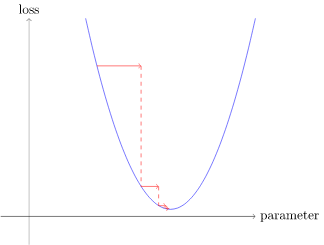

The matrix of gradients of all the weights:

$% <![CDATA[
\nabla (W) =
\begin{bmatrix}
\nabla (w_{0,0}) & \nabla (w_{0,1}) & \cdots & \nabla (w_{0,k}) \\
\nabla (w_{1,0}) & \nabla (w_{1,1}) & \cdots & \nabla (w_{1,k}) \\
\vdots  & \vdots  & \cdots & \vdots \\
\nabla (w_{n,0}) & \nabla (w_{n,1}) & \cdots & \nabla (w_{n,k})
\end{bmatrix}
\:\:and
\\ %]]>$

Vector of the gradients of all the biases:

$% <![CDATA[
\nabla (b) = 
\begin{bmatrix}
\nabla (b_{0}) & \nabla (b_{1}) & \cdots & \nabla (b_{k})
\end{bmatrix} %]]>$

Where,

$\nabla (w_{f,l}) = 
[\frac{1}{m} \sum_{i=0}^{m} \left( x_{i,f} * (y_{i, l} - a_{i, l}) \right)] + [2 \lambda * w_{f,l}]
\:\:and$



$\nabla (b_{l}) = \frac{1}{m} \sum_{i=0}^{m} \left( y_{i, l} - a_{i, l} \right)$

$f$ is the feature index, $l$ is the class label index, and $i$ is the specific simple/observation index. Note: that $y$ in this equation is one-hot encoded and of shape (m,k) were k is the number of classes.

The first term $\nabla (w_{f,l})$ is the gradient with respect to the cross entropy function and the second term is the gradient with respect to the L2 regularization term $[2 \lambda * w_{f,l}]$.



The update step looks like this:

$% <![CDATA[
W \mathrel{-}=
\begin{bmatrix}
\alpha \nabla (w_{0,0}) & \alpha \nabla (w_{0,1}) & \cdots & \alpha \nabla (w_{0,k}) \\
\alpha \nabla (w_{1,0}) & \alpha \nabla (w_{1,1}) & \cdots & \alpha \nabla (w_{1,k}) \\
\vdots  & \vdots  & \cdots & \vdots \\
\alpha \nabla (w_{n,0}) & \alpha \nabla (w_{n,1}) & \cdots & \alpha \nabla (w_{n,k})
\end{bmatrix}
\\ %]]>$

In [ ]:
lambda_param = 0.01
lr = 0.01

w_gradients = -torch.matmul(X.T, y_one_hot -A) / X.shape[0] + (2 * lambda_param * weights)
b_gradients = -torch.mean(y_one_hot - A, axis=0)

weights -= lr * w_gradients
bias -= lr * b_gradients

### **Defining the Loss Function**

We are going to use the cross-entropy loss function which takes the negative log-likelihood of the predicted probability assigned to the true label.



The cost function or loss function is how we determine the perfomance of the model at the end of each forward pass in the training process.

**Note**: Technically, the *loss* refers to the accuracy of a single observation prediction while the *cost* is the average loss of all m predictions.

$Cross\:Entropy\:Loss = -\frac{1}{m}\sum_{i=0}^{m} \sum_{j=0}^{k} y_{i,j} \cdot \log (a_{i,j})$


In [ ]:
def cross_entropy_loss(y_one_hot, activations):
  return -torch.mean(
      torch.sum(
          y_one_hot * torch.log(activations), axis=1
      )
  )

1. Multiply the one-hot labels by the log of the activations. It's important to note here that only one column per row in the product will be non-zero.
2. Get the row-sums (axis=1) of the tensor in step 1.
3. Return the negative mean of step 3. 

### **Define The Regularization**

**L2 Regularization**

Regularization refer to methods that try to prevent overfitting in machine learning models- we can usually tell we are overfitting the data when training loss keeps going down but validation loss increases. 

*L2 Regularization* simply adds a term to the cost function intended to *penalize model complexity.* It looks like this:

$L2\:Regularization\:Term\:= \big\|W\big\|^{2} = \sum_{i=0}^{n} \sum_{j=0}^{k} w_{i,j}^2$

We square every parameter $w$ in the weight matrix and take the sum. This is were the idea of penalizing complexity comes from - the sum gets bigger as the magnitude of the individual parameters or the number of them grows. Adding this term to the loss calculation has the effect of encouraging the model parameters towards zero. 

**Note:** In general, we want to pre-process the features in your dataset to be of the same scale, but this is especially important when using L2 regularization.

$L2\:Regularized\:Loss = -\frac{1}{m}\sum_{i=0}^{m} \sum_{j=0}^{k} y_{i,j} \cdot \log (a_{i,j}) + \lambda \sum_{i=0}^{n} \sum_{j=0}^{k} w_{i,j}^2$

Where $λ≥0$ is a hyperparameter to be tuned and $λ=0$ is equivalent to vanilla Cross Entropy Loss.

In [ ]:
l2_regularization = torch.sum(weights ** 2)
lambda_param = 0.01
loss = cross_entropy_loss(y_one_hot, A) + lambda_param * l2_regularization

### **Classification Accuracy**

In [ ]:
test_predictions = torch.argmax(softmax(torch.mm(valid_x, weights) + bias), axis=1)

In [ ]:
# Calculate accuracy percentage between two lists
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
accuracy_metric(valid_y, test_predictions)

14.799999999999999

### **Training**

In [ ]:
n_train = 60000

In [ ]:
n_iterations = 100
learning_rate = 0.01
lambda_param = 0.01
for i in range(1, n_iterations + 1):

    Z = torch.mm(X, weights) + bias
    A = softmax(Z)
    l2_regularization = torch.sum(weights ** 2)
    loss = cross_entropy_loss(y_one_hot, A) + lambda_param * l2_regularization
    w_gradients = -torch.mm(X.transpose(0, 1), y_one_hot - A) / n_train + (2 * lambda_param * weights)
    b_gradients = -torch.mean(y_one_hot - A, axis=0)

    weights -= learning_rate * w_gradients
    bias -= learning_rate * b_gradients

    if i == 1 or i % 25 == 0:
        print("Loss at iteration {}: {}".format(i, loss))

test_predictions = torch.argmax(softmax(torch.mm(valid_x, weights) + bias), axis=1)

test_accuracy = accuracy_metric(valid_y, test_predictions)
print("\nFinal Test Accuracy: {}".format(test_accuracy))

Loss at iteration 1: 85.1719970703125
Loss at iteration 25: 83.82386779785156
Loss at iteration 50: 82.50579833984375
Loss at iteration 75: 81.2599868774414
Loss at iteration 100: 80.07752227783203

Final Test Accuracy: 17.91


In [ ]:
Z = torch.mm(X, weights) + bias
A = softmax(Z)
l2_regularization = torch.sum(weights ** 2)
loss = cross_entropy_loss(y_one_hot, A)
loss

In [ ]:
Z = torch.matmul(train_x, weights) + bias
Z



All PyTorch Tensors have a requires_grad attribute that defaults to False. If we set this property to True when the tensor gets created, PyTorch will keep track of every computation we perform with it as a graph. Calling backward() on any tensor that descends from the original will propagate gradients all the way back up the graph, populating the Tensor.grad attribute for all parent tensors.

In [ ]:
weights = torch.randn((784, 10), requires_grad=True)
bias = torch.randn(10, requires_grad=True)

In [ ]:
n_iterations = 250
learning_rate = 0.1
lambda_param = 0.01
for i in range(1, n_iterations + 1):
    
    Z = torch.mm(X, weights) + bias
    A = softmax(Z)
    l2_regularization = torch.sum(weights ** 2)
    loss = cross_entropy_loss(y_one_hot, A) + lambda_param * l2_regularization

    if weights.grad is not None:
        weights.grad.zero_()  # 1
    if bias.grad is not None:
        bias.grad.zero_()

    loss.backward()  # 2
    
    with torch.no_grad():  # 3
        weights -= learning_rate * weights.grad
        bias -= learning_rate * bias.grad
    
    if i == 1 or i % 25 == 0:
        print("Loss at iteration {}: {}".format(i, loss))

test_predictions = torch.argmax(softmax(torch.mm(valid_x, weights) + bias), axis=1)

test_accuracy = accuracy_metric(valid_y, test_predictions)
print("\nFinal Test Accuracy: {}".format(test_accuracy))

Loss at iteration 1: 29.02509117126465
Loss at iteration 25: 26.34192657470703
Loss at iteration 50: 23.82099151611328
Loss at iteration 75: 21.550569534301758
Loss at iteration 100: 19.504758834838867
Loss at iteration 125: 17.66069221496582
Loss at iteration 150: 15.998042106628418
Loss at iteration 175: 14.498688697814941
Loss at iteration 200: 13.146411895751953
Loss at iteration 225: 11.926678657531738
Loss at iteration 250: 10.826428413391113

Final Test Accuracy: 80.9


Note: When we tell PyTorch to keep track of gradients they will keep acucmalating as a total sum every time we call backward(). We don't want this since we only ever want the gradients from the last step. Therefore we need to zero out the gradients for every tensor after we've updated them with ´tensor.grad.zero_(). (PyTorch uses the convetion of ending method names with an underscore for in-place changes.)


1. Zero out the gradients before calculating them again.
2. Calculate upstream gradients.
3. In order to not disrupt the computation graph that we rely on for gradient calculations, we need to update both ´weights´ and ´bias´ inside of a no_grad context manager.


### **Neural Network**


We are going to need a model, an activation function, an optimizer, and a loss function.

Our model will consits of:

1. Input layer: Here we will input our dataset, consisting of 28x28 pixel images of numbers 0-9. We are going to want to flatten the input into a rank 1 tensor with 28 x 28 = 784 elements. This means that the input layer will have 784 nodes. 

2. Hidden layer 1: In this layer, we will reduce the number of nodes from 784 coming from the input layer to 128 nodes.

3. Here we will go down to 64 nodes, from the 128 nodes in the previous layer.

4. Output layer: In the last layer we will reduce the input coming from the 64 nodes into 10 nodes that correspond to the 10 labels for our data. The labels will be received in the form of a rank-1 tensor with 10 elements corresponding to the numbers 0-9, where one of the elements will be 1 and the rest 0. The 1 will correspond to one of the numbers between 0-9.

Note: The number of nodes chosen is somewhat arbitrary and based on what others recommend in order to avoid overfitting and underfitting the data. 

Steps:

1. Initialization
2. Feedforward (predict)
3. Loss
4. Backpropagation (gradient) 
5. Step (update)
6. Back to step 2
7. Stop

#### **Initialization**

We want to initialize the neural network class by the init function:

When we call the initialization() function we are preparing mxn matrices that are fit for matrix multiplication to be used in the forward pass of our network. Since we want to shrink the number of nodes as the layers increase we use the rules of matrix multiplication to achieve this. The dot product operation for two matrices: M1 and M2 only works if the numbers of rows in M1 (m1) matches the number of columns in M2 (n). I.e. m x n dot m x n = n x n matrix. 

Therefore for the operation: w1@x + b we will need to initialize the first set of weights to be 128 x 784 to dot with X (784 x 128) (128 is the batch size).

The output Z1 will be of dimenations 128 x 128 thus W2 will be 128 x 64

The output Z2 will be of dimensions 128 x 64 thus W3 will be 64 x 10.

In [ ]:
train_x.shape

#### **Feedforward Pass**

In this step we are doing the linear predictions w@x + b and passing our outputs through the activation functions to ultimately get a probabily of each class, so that we can measure how well the forward pass performs:

We use the two following activation functions in this network:

1. Sigmoid activation:
2. Softmax activation:

#### **Backpropagation**

In order to get the backward pass to right all the shapes need to correct for all the operations:


W3 Update: The update for W3 is calculated by subtracting the true labels from the predicted labels. Our loss function is the sum of squared differences and we have taken it's derivative (that's why we are multiplying by 2 and not raising it to 2) we take this product with the derivative of the softmax function Z3. Then last step is to take the outer product of the error with the activations A2.

W2 Update: Next up is updating W2. There's a slight mismatch in shapes as W3 has the shape (10, 64) and the error is also (10,64). Thus we take the transpose of W3 to make the shapes align for the dot product. The result is the Hadamard product with the outcome of the derivative of the sigmoid function Z2. The last step is to take the outer product of the error and the activations A1.

W1 Update: Next up is updating W1. This is essentially the same as the W2 except we are using other parameters. 

#### **Training with Stochastic Gradient Descent (SGD)**

Now that we have a forward and backward pass, we need a way to use them. We can do this by making a training loop and use Stochastic Gradient Descent as the optimizer to update our parameters of the network.

We have two main loops in the function: One for the number of epochs, which is the number of times we run through the dataset and train our parameters, and the second loop is for running through each observation one by one. 

For each observation, we do a forward pass with `x`, which is one image in an 1 dimensional tensor with the length of 784 (28x28). The ´output´ of the forward pass isued along with ´y´, which are the one-hot encoded labels, in the backward pass. This gives us a dictionary of updates to our weights in the network. 

Training process can be simplified as a loop **forward pass -> compute loss -> back propagation -> update weights and bias -> forward pass**


In [ ]:
train_x.shape